<a href="https://colab.research.google.com/github/bluedataconsulting/Orbit-AI-Mastery-TTT-/blob/main/Module9/DCGANs_with_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
(xtrain,ytrain),(xtest,ytest) = mnist.load_data()
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<Figure size 864x1440 with 0 Axes>

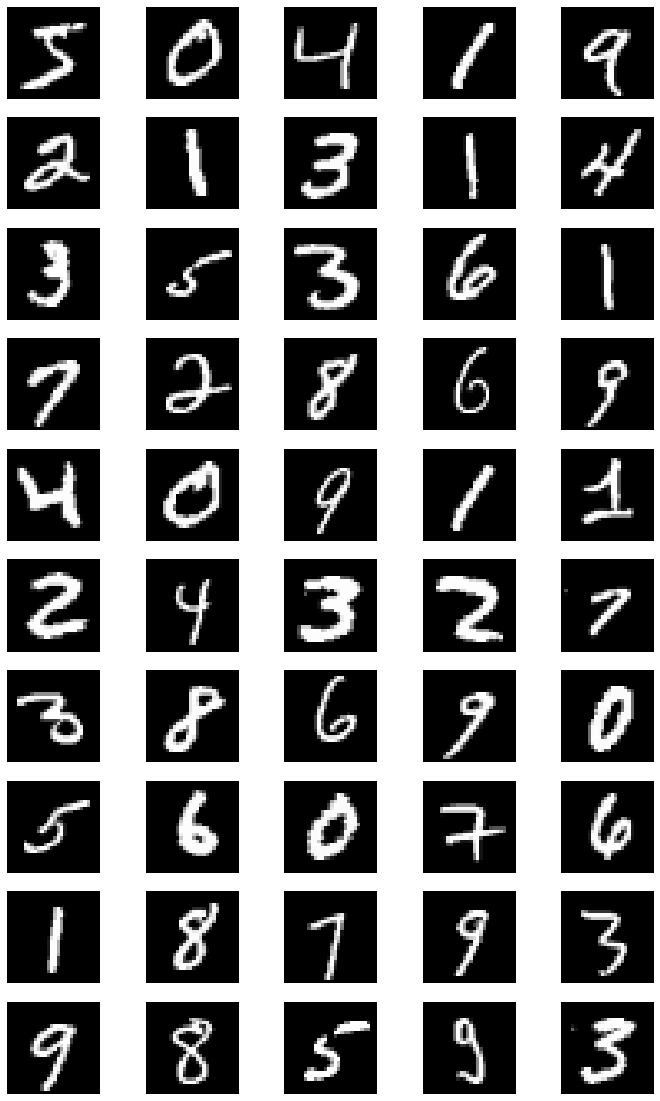

In [5]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(10,5,figsize=(12,20))
axes = axes.flatten()
for ax,i in zip(axes,range(50)):
  ax.imshow(xtrain[i],cmap='gray')
  ax.axis(False)
plt.show()

# Modelling GANs

In [6]:
from tensorflow.keras import models,layers

In [ ]:
# Generator
# generator will accept x arrays of size 100 where x = batchsize
gen_input = layers.Input(shape=100)
x = layers.Dense(128*7*7,activation="tanh")(gen_input)
x = layers.BatchNormalization()(x)
x = layers.Reshape((7,7,128))(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='tanh')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D()(x)
gen_output = layers.Conv2D(filters=1,kernel_size=(5,5),padding='same',activation='tanh')(x)

gen_model = models.Model(inputs=gen_input,outputs=gen_output)
gen_model.compile(loss="binary_crossentropy",optimizer='adam')
gen_model.summary()

In [8]:
# Discriminator
dis_input = layers.Input(shape=(28,28,1))
x = layers.Conv2D(filters=64,kernel_size=(5,5),padding='same',strides=(2,2),activation='relu')(dis_input)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=128,kernel_size=(5,5),padding='same',strides=(2,2),activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
dis_output = layers.Dense(1,activation='sigmoid')(x)

dis_model = models.Model(inputs=dis_input,outputs=dis_output)
dis_model.compile(loss="binary_crossentropy",optimizer='adam')
dis_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273

In [9]:
# creating GAN model using both generator and discriminators
# create input for GAN
dis_model.trainable = False
gan_input = layers.Input(shape=(100,))
x = gen_model(gan_input) # getting x as output of  generator model (fake images)
gan_output = dis_model(x)  # getting output of discriminator model on fake images produced by generator
gan = models.Model(inputs=gan_input,outputs=gan_output)
gan.compile(loss="binary_crossentropy",optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         865281    
                                                                 
 model_1 (Functional)        (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [10]:
xtrain = xtrain.reshape(60000,28,28,1)
xtest = xtest.reshape(10000,28,28,1)
xtrain = xtrain.astype('float32')
# scale the images
xtrain = (xtrain - 127.5) / 127.5


In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# training the model
epochs = 30
batch_size=100
batch_count = xtrain.shape[0]//batch_size

for i in range(epochs):
  loss= []
  for j in range(batch_count):
    # random input for generator
    noise_input = np.random.rand(batch_size,100)
    # preparing input training for discriminator
    gen_prediction = gen_model.predict(noise_input,batch_size=batch_size) # feeding noise input to generator to get fake images as prediction(count = batch_size)
    real_images = xtrain[np.random.randint(0,xtrain.shape[0],batch_size)] # collecting realimages (count = batch_size)
    X_dis = np.concatenate([gen_prediction,real_images]) # concatenating fake and real images to prepare training data to train discriminator
    Y_dis = np.array([0]*batch_size + [1]*batch_size).reshape(-1,1) # preparing labels , real =1, fake = 0  for discriminator training data

    ######################################################
    ##### Train the model ##################
    dis_model.trainable = True # making discriminator trainable
    dis_model.train_on_batch(X_dis,Y_dis) # training the discriminator model with real and fake data, real with label =1, fake with label = 0

    ##### Train the generator #####
    noise_input = np.random.rand(batch_size,100) # getting noisy input of shape batch_size, 100
    y_generator = np.array([[1]*batch_size]).reshape(-1,1) # Creating label as fake = 1
    dis_model.trainable = False # making discriminator non trainable (now discriminator will only make predictions, its weights and bias wont update)
    model_loss = gan.train_on_batch(noise_input,y_generator) # Traiing the GAN with generator data
    loss.append(model_loss)
  print("Epoch ",i," completed")
  print("Loss of GAN is ",sum(loss)/len(loss))


Epoch  0  completed
Loss of GAN is  1.9075379745165506
Epoch  1  completed
Loss of GAN is  1.5450139023860296
Epoch  2  completed
Loss of GAN is  1.449922227760156
Epoch  3  completed
Loss of GAN is  1.435696310599645
Epoch  4  completed
Loss of GAN is  1.4826089712977408
Epoch  5  completed
Loss of GAN is  1.669206629594167
Epoch  6  completed
Loss of GAN is  1.7736774959166846
Epoch  7  completed
Loss of GAN is  1.8940884602069854
Epoch  8  completed
Loss of GAN is  2.0439847844839094
Epoch  9  completed
Loss of GAN is  2.06939950744311
Epoch  10  completed
Loss of GAN is  2.1613678534825644
Epoch  11  completed
Loss of GAN is  2.1714087891578675
Epoch  12  completed
Loss of GAN is  2.2370976932843525
Epoch  13  completed
Loss of GAN is  2.2610797081391016
Epoch  14  completed
Loss of GAN is  2.3121102462212244
Epoch  15  completed
Loss of GAN is  2.2919026956955593
Epoch  16  completed
Loss of GAN is  2.351014276345571


KeyboardInterrupt: ignored

(50, 28, 28, 1)


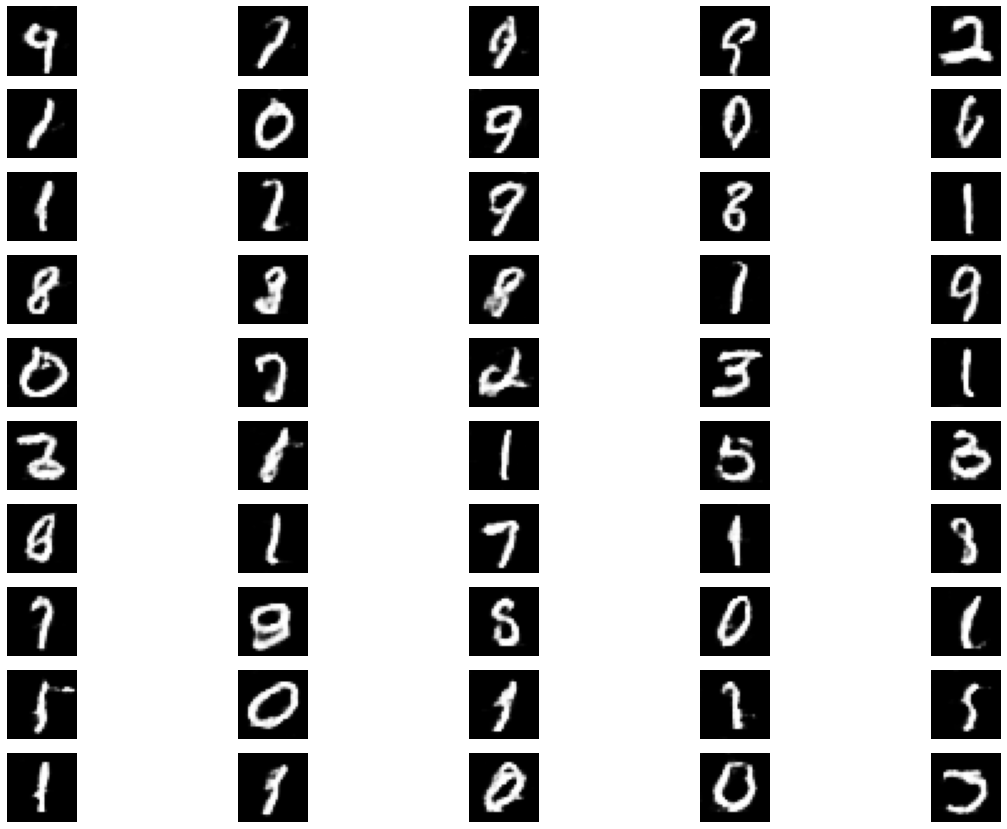

In [14]:
noise_input = np.random.rand(50,100)
prediction = gen_model.predict(noise_input)
print(prediction.shape)
plt.figure(figsize=(20,15))
for i in range(50):
  plt.subplot(10,5,i+1)
  plt.imshow(prediction[i,:,:,0],cmap='gray')
  plt.axis('off')
plt.show()